In [4]:
# Setup & Load Data

# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv("Fraud_Subset_50_50_10k_each.csv")  # Ensure the correct file path

# Display basic info
df.info()
df.head()
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   fraud                      20000 non-null  int64  
 1   trustLevel                 20000 non-null  int64  
 2   totalScanTimeInSeconds     20000 non-null  int64  
 3   lineItemVoids              20000 non-null  int64  
 4   quantityModification       20000 non-null  int64  
 5   grandTotal                 20000 non-null  float64
 6   scannedLineItemsPerSecond  20000 non-null  float64
 7   valuePerSecond             20000 non-null  float64
 8   lineItemVoidsPerPosition   20000 non-null  float64
 9   scansWithoutRegistration   20000 non-null  int64  
dtypes: float64(4), int64(6)
memory usage: 1.5 MB


,fraud,trustLevel,totalScanTimeInSeconds,lineItemVoids,quantityModification,grandTotal,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,scansWithoutRegistration
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,0.500000,2.423400,1029.035550,6.002000,2.499200,50.363867,0.055049,0.149222,0.499350,5.547350
std,0.500013,1.705954,518.224282,3.422496,1.711592,28.490840,0.431907,1.165267,0.970803,3.135961
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000547,0.000000,0.000000,0.000000
25%,0.000000,1.000000,591.000000,3.000000,1.000000,26.157500,0.013861,0.025379,0.153846,3.000000
50%,0.500000,2.000000,1085.000000,6.000000,2.000000,50.400000,0.019568,0.048841,0.300000,6.000000
75%,1.000000,4.000000,1486.000000,9.000000,4.000000,74.900000,0.034279,0.086795,0.434783,8.000000
max,1.000000,6.000000,1831.000000,11.000000,5.000000,99.990000,30.000000,70.840000,11.000000,10.000000


Missing Values:
 fraud                        0
trustLevel                   0
totalScanTimeInSeconds       0
lineItemVoids                0
quantityModification         0
grandTotal                   0
scannedLineItemsPerSecond    0
valuePerSecond               0
lineItemVoidsPerPosition     0
scansWithoutRegistration     0
dtype: int64

Duplicate Rows: 0


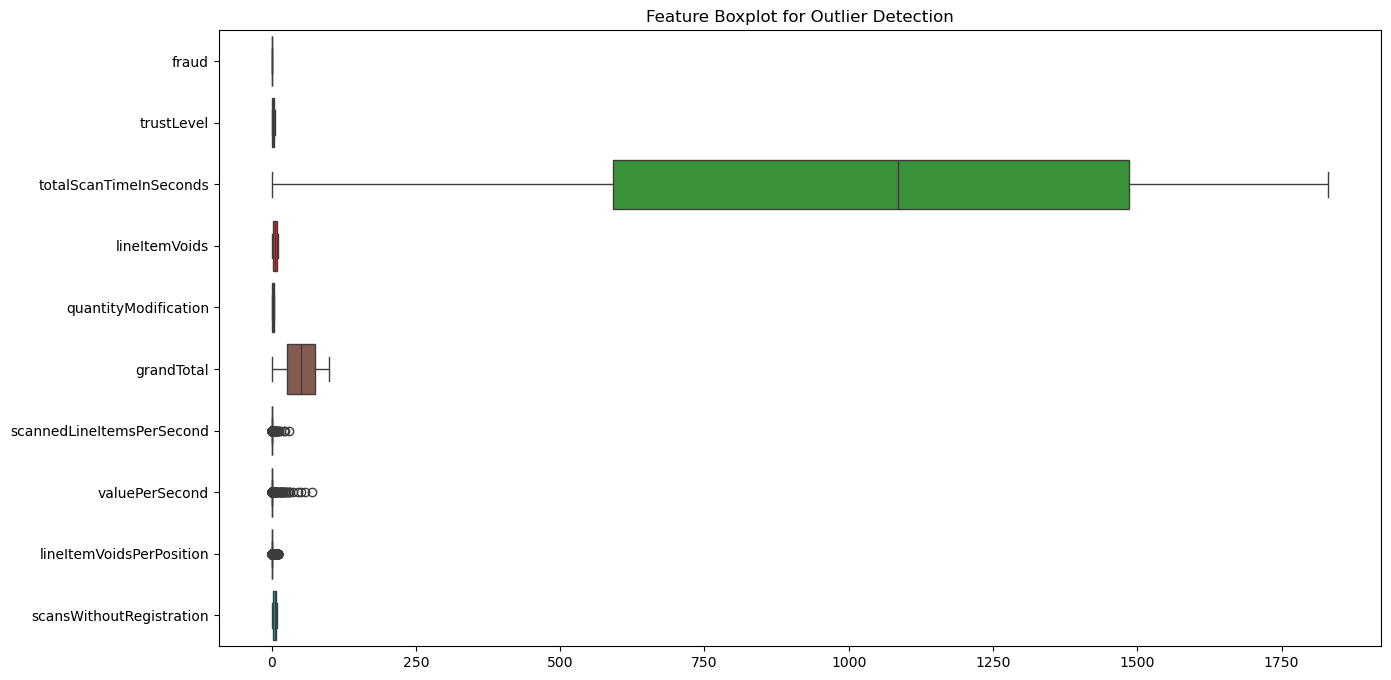

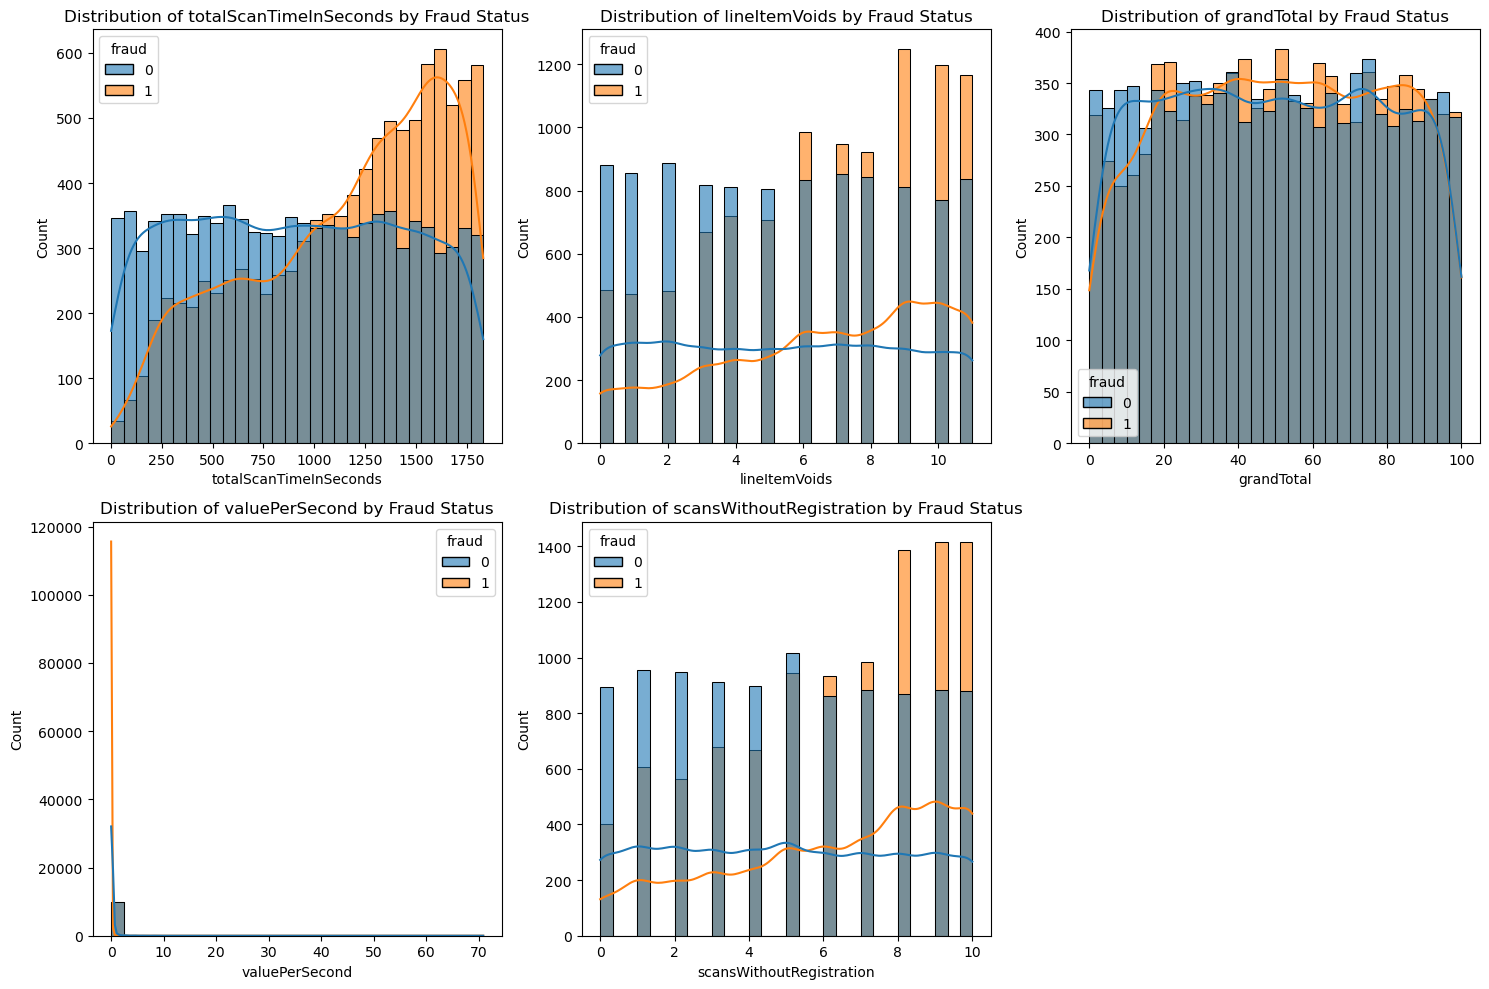

In [6]:
# Data Exploration & Cleaning

# Check for missing values
print("Missing Values:\n", df.isnull().sum())

# Check for duplicates
print("\nDuplicate Rows:", df.duplicated().sum())

# Visualize outliers using boxplots
plt.figure(figsize=(15, 8))
sns.boxplot(data=df, orient="h")
plt.title("Feature Boxplot for Outlier Detection")
plt.show()

Define IQR method to remove extreme outliers
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)] 

# Apply outlier removal to numerical columns
num_cols = ['totalScanTimeInSeconds', 'grandTotal', 'valuePerSecond', 'scannedLineItemsPerSecond']
for col in num_cols:
    df = remove_outliers(df, col)

# Visualize feature distributions by fraud status
plt.figure(figsize=(15, 10))
features_to_plot = ["totalScanTimeInSeconds", "lineItemVoids", "grandTotal", "valuePerSecond", "scansWithoutRegistration"]

for i, feature in enumerate(features_to_plot, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df, x=feature, hue="fraud", kde=True, bins=30, alpha=0.6)
    plt.title(f"Distribution of {feature} by Fraud Status")

plt.tight_layout()
plt.show()


In the exploratory data analysis phase, we focused on detecting outliers and understanding the feature behavior with respect to fraud status. The boxplot visualization revealed the presence of strong outliers in several variables, especially in valuePerSecond, scannedLineItemsPerSecond, and scansWithoutRegistration. These outliers were appropriately handled using the IQR method to ensure model robustness. Further, distribution plots comparing fraudulent and non-fraudulent transactions highlighted key behavioral differences. Fraudulent transactions often exhibited longer scan times, higher frequency of item voids, and more scan attempts without registration — all potentially suspicious patterns. In contrast, the grandTotal feature showed minimal distinction between classes, suggesting limited predictive power on its own. These insights guided my feature selection and model design in later stages.

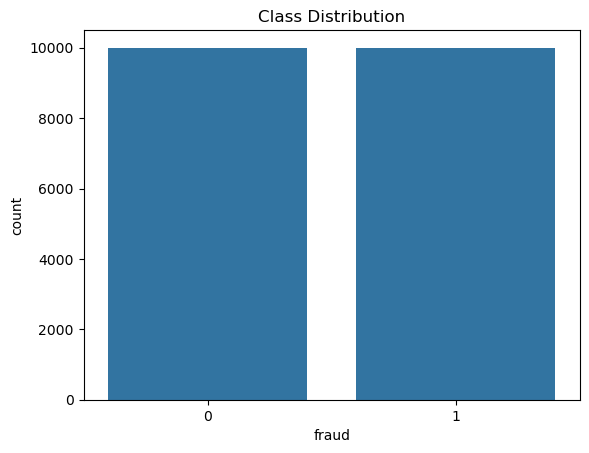

Class distribution (%):
fraud
1    50.0
0    50.0
Name: proportion, dtype: float64


In [15]:
# Visualize class distribution
sns.countplot(x='fraud', data=df)
plt.title('Class Distribution')
plt.show()

# Print class percentages
print("Class distribution (%):")
print(df['fraud'].value_counts(normalize=True) * 100)



In [9]:
#  Feature Engineering & Scaling

from sklearn.preprocessing import StandardScaler

# Features to keep (Based on previous analysis)
selected_features = [
    "trustLevel", "totalScanTimeInSeconds", "lineItemVoids", 
    "quantityModification", "grandTotal", "scannedLineItemsPerSecond", 
    "valuePerSecond", "lineItemVoidsPerPosition", "scansWithoutRegistration"
]

# Target variable
X = df[selected_features]  # Independent variables
y = df["fraud"]  # Dependent variable (0 or 1)

# Apply Standardization (Z-score scaling)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Standardize the features

# Convert back to a DataFrame
X = pd.DataFrame(X_scaled, columns=selected_features)

# Display the transformed dataset
X.head()


,trustLevel,totalScanTimeInSeconds,lineItemVoids,quantityModification,grandTotal,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,scansWithoutRegistration
0,-0.834393,1.177057,0.875991,-0.291666,1.481781,-0.085078,-0.079586,-0.205350,1.419903
1,-0.248196,0.630948,-0.584968,0.292600,-1.101219,-0.076233,-0.116043,-0.377034,0.782124
2,-0.834393,0.158168,-0.292776,1.461133,0.469852,-0.064937,-0.078818,-0.342697,-0.174544
3,-0.834393,-0.274088,0.583799,-1.460198,1.021622,-0.059589,-0.051172,-0.197427,0.782124
4,-0.834393,1.103728,0.291607,-0.875932,-0.370439,-0.089857,-0.106722,-0.237045,-1.450102


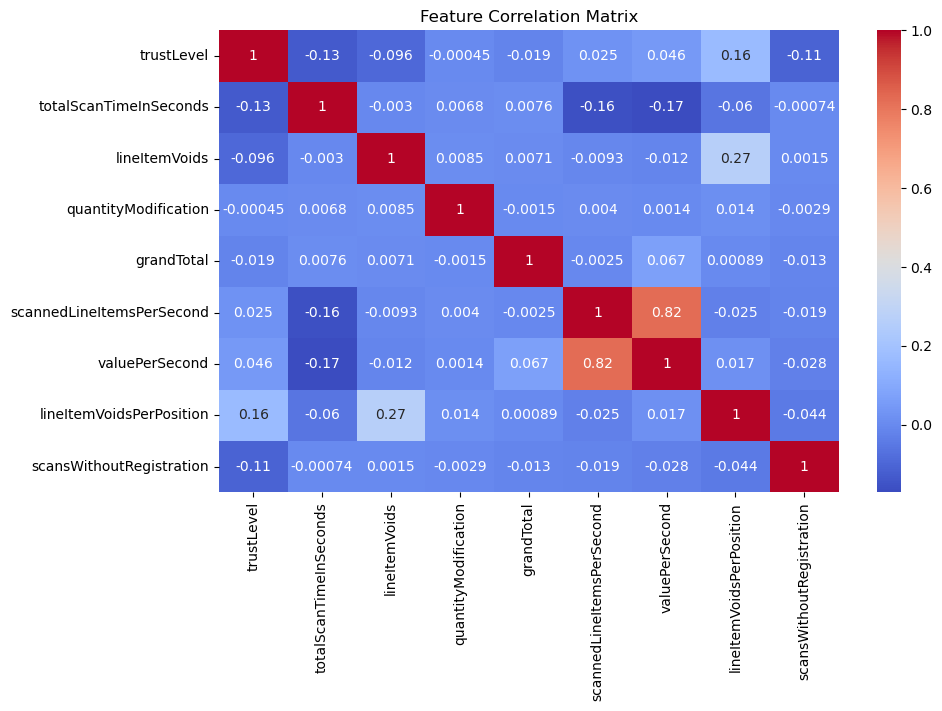

In [16]:
# Visualize feature correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(X.corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.show()

The correlation matrix analysis confirmed that most features are weakly correlated, minimizing the risk of multicollinearity in the logistic regression model. The only notable exception is the strong correlation (0.82) between scannedLineItemsPerSecond and valuePerSecond, which aligns with domain logic. While both features are retained for now to preserve model performance, they may be revisited during feature importance or model refinement steps. Overall, the selected features appear well-suited for modeling, requiring no immediate removals or transformations.

Accuracy: 0.9690
Precision: 0.9467
Recall: 0.9940
F1-score: 0.9698
ROC-AUC: 0.9948


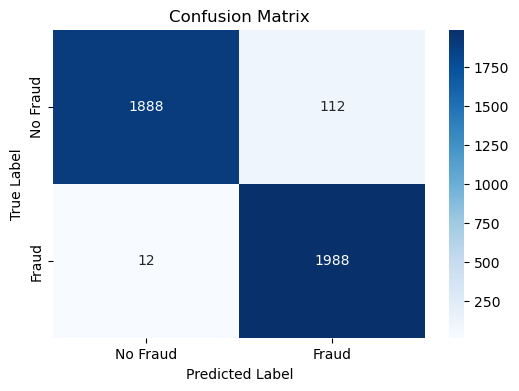

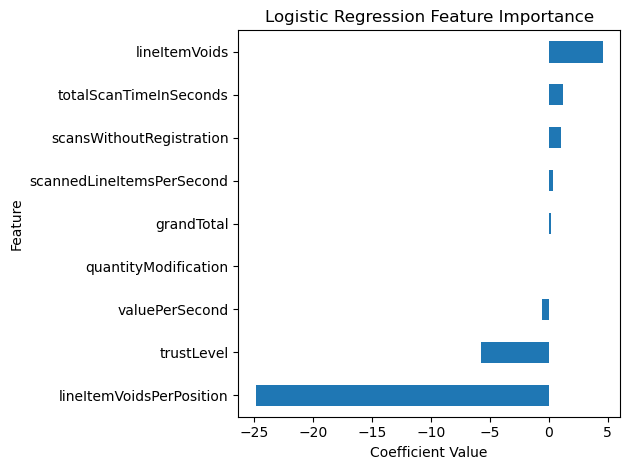

In [18]:
#  Train & Evaluate Logistic Regression Model

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Split the dataset into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize and train Logistic Regression model
model = LogisticRegression(class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

# Predict on test data
y_pred = model.predict(X_test)

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])  # Probability-based ROC AUC

# Print evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")

# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues", xticklabels=["No Fraud", "Fraud"], yticklabels=["No Fraud", "Fraud"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Visualize feature importance (logistic regression coefficients)
importance = pd.Series(model.coef_[0], index=X.columns)
importance.sort_values().plot(kind='barh')
plt.title("Logistic Regression Feature Importance")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()



The logistic regression model achieved strong classification performance, with an accuracy of 96.9%, a precision of 94.67%, and a near-perfect recall of 99.4%, indicating excellent sensitivity to fraudulent behavior. The model correctly identified nearly all fraudulent transactions while maintaining a relatively low false positive rate. From a feature importance perspective, lineItemVoidsPerPosition emerged as the most influential negative predictor of fraud, meaning higher values strongly increased the likelihood of fraud classification. This aligns with real-world expectations, where a higher frequency of voids per item suggests suspicious behavior. Other key indicators included the raw number of voided items (lineItemVoids) and customer trustLevel. These insights provide transparency into the model’s decision-making and can guide future rule-based screening or policy adjustments.

Best C parameter: 100

Threshold: 0.4
              precision    recall  f1-score   support

           0       0.99      0.96      0.97      2000
           1       0.96      0.99      0.98      2000

    accuracy                           0.98      4000
   macro avg       0.98      0.98      0.98      4000
weighted avg       0.98      0.98      0.98      4000



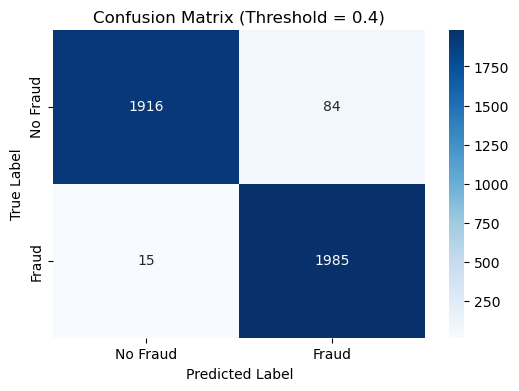


Threshold: 0.5
              precision    recall  f1-score   support

           0       0.99      0.96      0.98      2000
           1       0.97      0.99      0.98      2000

    accuracy                           0.98      4000
   macro avg       0.98      0.98      0.98      4000
weighted avg       0.98      0.98      0.98      4000



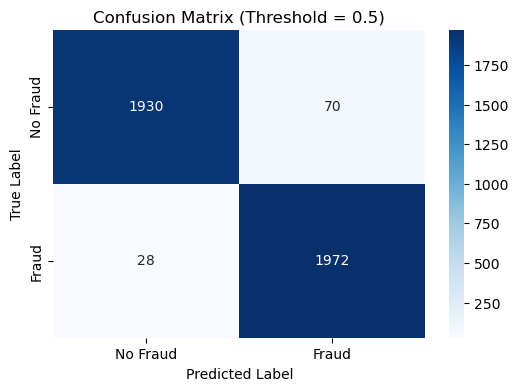


Threshold: 0.6
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      2000
           1       0.97      0.97      0.97      2000

    accuracy                           0.97      4000
   macro avg       0.97      0.97      0.97      4000
weighted avg       0.97      0.97      0.97      4000



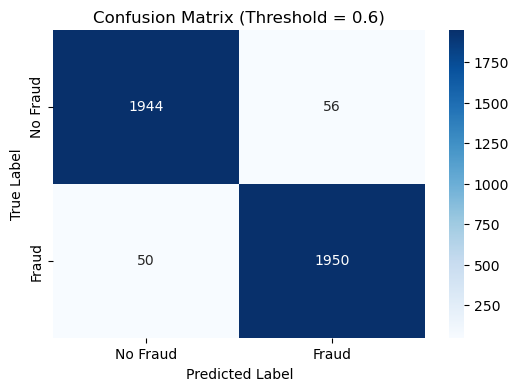

In [13]:
# Step 5: Fine-Tuning Logistic Regression + Confusion Matrix

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

# Define hyperparameter grid for Logistic Regression
param_grid = {"C": [0.001, 0.01, 0.1, 1, 10, 100]}

# Perform Grid Search with 5-fold cross-validation
grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring="f1")
grid_search.fit(X_train, y_train)

# Best hyperparameter
best_C = grid_search.best_params_["C"]
print(f"Best C parameter: {best_C}")

# Train Logistic Regression with the best C
model_tuned = LogisticRegression(C=best_C)
model_tuned.fit(X_train, y_train)

# Predict probabilities
y_prob = model_tuned.predict_proba(X_test)[:, 1]  # Probabilities for class 1 (fraud)

# Thresholds to evaluate
thresholds = [0.4, 0.5, 0.6]

for thresh in thresholds:
    print(f"\nThreshold: {thresh}")
    y_pred_thresh = (y_prob >= thresh).astype(int)

    # Classification Report
    print(classification_report(y_test, y_pred_thresh))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred_thresh)

    # Plotting Confusion Matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=["No Fraud", "Fraud"], 
                yticklabels=["No Fraud", "Fraud"])
    plt.title(f"Confusion Matrix (Threshold = {thresh})")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()


To improve the classification performance of the logistic regression model, we explored threshold tuning to shift the default decision boundary from 0.5. Using different thresholds (0.4, 0.5, 0.6), we evaluated their impact on key metrics such as precision, recall, and F1-score. A threshold of 0.4 offered the highest recall (99%) with very few false negatives, making it ideal for minimizing undetected fraud at the cost of a few more false positives. The default threshold of 0.5 balanced precision and recall well, while a threshold of 0.6 reduced false positives but allowed more fraud cases to slip through. Ultimately, the best threshold depends on the business’s tolerance for missed fraud versus incorrect flagging of honest customers. In this case, a threshold of 0.4 or 0.5 appears optimal, offering strong fraud detection without significantly increasing false alarms.


In [9]:
# Step 6: Save & Load Model for Deployment

import joblib

# Define the final model with the chosen threshold
final_threshold = 0.5  # Change this to 0.4 or 0.6 based on preference

# Save the trained model & scaler
joblib.dump(model_tuned, "fraud_detection_model.pkl")
joblib.dump(scaler, "scaler.pkl")

print("Model and scaler saved successfully!")

# ----- Verify loading -----
# Load the model & scaler
loaded_model = joblib.load("fraud_detection_model.pkl")
loaded_scaler = joblib.load("scaler.pkl")


Model and scaler saved successfully!
